In [2]:
import os
import pickle
import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import color

import imgaug.augmenters as iaa

import torch
from torch import cat
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [3]:
PROJECT_PATH = '.'
DATASETS_PATH = f'{PROJECT_PATH}/Datasets'
BASE_PATH = f'{PROJECT_PATH}/Recortes'
TARGET_SIZE = (128, 128)
CANTIDAD_DE_AUMENTOS = 3

In [4]:
def pad_with_average(image_path, target_size):
    # Leer la imagen con PIL
    image = Image.open(image_path)

    # Determinar las dimensiones para el redimensionamiento proporcional
    aspect_ratio = image.width / image.height
    if aspect_ratio > 1:
        # La imagen es más ancha que alta
        new_width = target_size[1]
        new_height = int(new_width / aspect_ratio)
    else:
        # La imagen es más alta que ancha
        new_height = target_size[0]
        new_width = int(new_height * aspect_ratio)

    # Redimensionar la imagen
    image = image.resize((new_width, new_height), Image.LANCZOS)

    # Convertir la imagen a un array para calcular el color promedio
    image_np = np.asarray(image)
    avg_color = tuple(map(int, np.mean(image_np, axis=(0, 1))))

    # Calcular cuánto padding es necesario
    delta_w = target_size[1] - new_width
    delta_h = target_size[0] - new_height
    padding = (delta_w//2, delta_h//2)

    # Aplicar padding con el valor promedio
    padded_image = Image.new(image.mode, target_size, avg_color)
    padded_image.paste(image, padding)

    padded_image = np.array(padded_image)

    return padded_image

In [5]:
def plot_hists(heights_list, widths_list):
    # Grafica histograma de  Alturas
    plt.hist(heights_list, edgecolor='k', alpha=0.7, color='c', bins=20, range=(1, 800))
    plt.title('Distribution de alturas')
    plt.xlabel('Altura (en pixeles)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    # Grafica histograma de  Anchos
    plt.hist(widths_list, edgecolor='k', alpha=0.7, color='c', bins=20, range=(1, 800))
    plt.title('Distribución de anchos')
    plt.xlabel('Anchura (en pixeles)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    # Grafica histograma de Radios
    ratio_list = np.array(heights_list) / np.array(widths_list)
    plt.hist(ratio_list, edgecolor='k', alpha=0.7, color='c', bins=20, range=(0, 3))
    plt.title('Distribución de ratios')
    plt.xlabel('Ratio')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    # Grafica histograma de Áreas
    ratio_list = np.array(heights_list) * np.array(widths_list)
    plt.hist(ratio_list, edgecolor='k', alpha=0.7, color='c', bins=20, range=(1, 4e5))
    plt.title('Distribución de resoluciones')
    plt.xlabel('Resolución (en pixeles)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

In [6]:
def generate_crops(output_dir, annotations_dir, images_dir):
    # Dimensiones mínimas aceptables para la imagen recortada
    min_width = 50  # Ancho mínimo en píxeles
    min_height = 50  # Altura mínima en píxeles
    img_heights = [] # Lista que almacena alturas de todas las imágenes
    img_widths = [] # Lista que almacena el ancho de todas las imágenes
    img_final_height = 10
    img_final_width = 10

    # Crear el directorio de salida si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterar sobre cada subdirectorio en el directorio de anotaciones
    for folder in os.listdir(annotations_dir):
        annotation_folder_path = os.path.join(annotations_dir, folder)
        image_folder_path = os.path.join(images_dir, folder)
        output_folder_path = os.path.join(output_dir, folder)

        # Crear el subdirectorio de salida correspondiente si no existe
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)


        # Iterar sobre cada archivo de anotación en el subdirectorio
        for filename in os.listdir(annotation_folder_path):
            annotation_file_path = os.path.join(annotation_folder_path, filename)
            image_file_path = os.path.join(image_folder_path, f"{filename}.jpg")

            # Leer el archivo XML
            tree = ET.parse(annotation_file_path)
            root = tree.getroot()

            # Cargar la imagen original
            img = Image.open(image_file_path)

            # Contador para múltiples anotaciones
            count = 0

            # Obtener las dimensiones del cuadro delimitador (bounding box)
            for obj in root.iter('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Verificar si el cuadro delimitador es demasiado pequeño
                if xmax - xmin < min_width or ymax - ymin < min_height:
                    print(f"El cuadro delimitador en {filename} es demasiado pequeño. Se omite.")
                    continue  # Saltar al siguiente ciclo del bucle

                # Extraer la parte de interés
                cropped_img = img.crop((xmin, ymin, xmax, ymax))

                # Convertir a RGB si es necesario
                if cropped_img.mode == 'RGBA':
                    cropped_img = cropped_img.convert("RGB")

                # Determinar propiedades de la imagen
                width, height = cropped_img.size
                img_widths.append(width)
                img_heights.append(height)

                # Nombre del archivo de salida para múltiples anotaciones
                output_file_path = os.path.join(output_folder_path, f"{filename}_recortado_{count}.jpg")

                # Guardar la imagen recortada
                cropped_img.save(output_file_path)

                # Incrementar el contador para la siguiente anotación
                count += 1
    # Grafica los histogramas de las imágenes recortadas
    plot_hists(img_heights, img_widths)

In [7]:
def generate_datasets(base_path):
    class_folders = os.listdir(base_path)

    data = []
    labels = []
    label_to_folder = {}  # Diccionario para almacenar la relación label-folder

    for label, folder_name in enumerate(class_folders):
        folder_path = os.path.join(base_path, folder_name)

        if os.path.isdir(folder_path):
            # Guardar en el diccionario la relación label-folder
            label_to_folder[label] = folder_name

            for image_name in os.listdir(folder_path):
                if image_name.endswith(('.png', '.jpg', '.jpeg')):
                    data.append(os.path.join(folder_path, image_name))
                    labels.append(label)


    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    return train_data, test_data, train_labels, test_labels, label_to_folder  # Incluir el diccionario en la respuesta


In [8]:
def augment_images(seq, image_rgb, num_augmented=CANTIDAD_DE_AUMENTOS):
    # Aplica la secuencia de aumentación a la imagen original
    augmented_images = seq(images=[image_rgb] * num_augmented)
    # Produce (yield) cada imagen aumentada una por una
    for augmented_image in augmented_images:
        yield augmented_image

In [9]:
def get_features_single_image(imagen):
    # Asegurarte de que la imagen esté en escala de grises, si es necesario
    if len(imagen.shape) == 3:
        image_gs = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)

    # Preparar el descriptor y el detector de HOG
    hog = cv2.HOGDescriptor()

    # Calcular el descriptor HOG
    h = hog.compute(image_gs)

    return np.hstack([imagen.flatten(), h.flatten()])


In [10]:
def get_features(train_imgs, train_labels, output_path=None):
    # Listas para almacenar las imágenes y las etiquetas
    train_images = []
    augmented_labels = []

    total_images = len(train_imgs)
    count = 0
    # Define la secuencia de aumentación
    seq = iaa.Sequential([
        iaa.Crop(px=(0, 16)),  # recorta imágenes de cada lado por 0 a 16px (aleatoriamente elegido)
        iaa.Fliplr(0.5),  # refleja horizontalmente el 50% de las imágenes
        iaa.GaussianBlur(sigma=(0, 3.0))  # aplica desenfoque gaussiano con un sigma de 0 a 3.0
    ])
    size_0 = None
    # Procesar imágenes de entrenamiento
    for img_idx, img_path in enumerate(train_imgs):
        count += 1
        if count % 100 == 0:
            print(f"Processing image {count}/{total_images}")

        image = pad_with_average(img_path, TARGET_SIZE)

        if count % 100 == 0:
            print(f"Processing image {count}/{total_images}")

        image = pad_with_average(img_path, TARGET_SIZE)
    
        train_images.append(get_features_single_image(image))
        augmented_labels.append(train_labels[img_idx])  # Agrega el label para la imagen original

        for augmented_image in augment_images(seq, image):
            train_images.append(get_features_single_image(image))
            augmented_labels.append(train_labels[img_idx])  # Agrega el mismo label para cada imagen aumentada

    # Convertir las listas a arrays de numpy
    train_images = np.stack(train_images, axis=0)
    augmented_labels = np.array(augmented_labels)

    if output_path is not None:
        np.save(output_path, train_images)

    return train_images, augmented_labels


In [11]:
def get_dataloader(images, labels, batch_size=128):
    # Asumiendo que tus datos están en arrays de NumPy 'X_train_np' y 'y_train_np'
    X_train = torch.from_numpy(images).float()  # Asegúrate de que sean floats para los inputs
    y_train = torch.from_numpy(labels).long()  # Asegúrate de que sean long para los labels si estás en un contexto de clasificación

    # Creando un TensorDataset
    train_dataset = TensorDataset(X_train, y_train)

    # Creando un DataLoader
    batch_size = 64  # Puedes ajustar esto dependiendo de tu sistema
    return DataLoader(dataset=train_dataset, batch_size=batch_size)

In [12]:
class ShallowNet(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=50, dropout_rate=0.5):
        super(ShallowNet, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa de Dropout
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.norm(x)
        x = F.relu(self.fc1(x))

        # Aplicando el Dropout después de la activación ReLU y antes de la siguiente capa lineal
        x = self.dropout(x)

        x = self.fc2(x)
        return x

In [13]:
def train(train_loader, val_loader, num_features, model, num_epochs=10):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"There are {torch.cuda.device_count()} GPU(s) available.")
        print("Device name:", torch.cuda.get_device_name(0))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    model = model.to(device)

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        model.train()  # Entrenamiento del modelo
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Envuelves tu iterador con tqdm para crear una barra de progreso
        progress_bar = tqdm(enumerate(train_loader, 0), total=len(train_loader))

        for i, data in progress_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # cero los gradientes de los parámetros
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calcular la precisión
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Actualizar la barra de progreso
            running_loss += loss.item()
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            progress_bar.set_postfix(loss=(running_loss / (i + 1)))

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_acc)

        print(f"[{epoch + 1}] loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.2f}%")

        # Ahora la parte de validación (evaluación) después de cada época
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:  # asumiendo que val_loader es tu DataLoader de validación
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calcular la precisión
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val

        val_loss_history.append(epoch_val_loss)
        val_accuracy_history.append(epoch_val_acc)

        print(f"Validation loss: {epoch_val_loss:.4f}, Validation accuracy: {epoch_val_acc:.2f}%")

    print('Finished Training')

    return val_loss_history, val_accuracy_history, train_loss_history, train_accuracy_history

In [14]:
def plot_history(val_loss, val_accuracy, train_loss, train_accuracy):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Loss During Training and Validation")
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Accuracy During Training and Validation")
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
def plot_histograms():
    # Grafica los histogramas de las imágenes recortadas
    img_heights = []
    img_widths = []
    for folder in os.listdir(BASE_PATH):
        for image_output_path in os.listdir(os.path.join(BASE_PATH, folder)):
          img = Image.open(os.path.join(os.path.join(BASE_PATH, folder), image_output_path))
          # Determinar propiedades de la imagen
          width, height = img.size
          img_widths.append(width)
          img_heights.append(height)
    plot_hists(img_heights, img_widths)

In [16]:
train_paths, test_paths, train_labels, test_labels, label_to_dirname = generate_datasets(BASE_PATH)

if not os.path.exists(DATASETS_PATH):
    os.makedirs(DATASETS_PATH)

train_images, train_labels = get_features(train_paths, train_labels)

test_images, test_labels = get_features(test_paths, test_labels)

Processing image 100/17640
Processing image 200/17640
Processing image 300/17640
Processing image 400/17640
Processing image 500/17640
Processing image 600/17640
Processing image 700/17640
Processing image 800/17640
Processing image 900/17640
Processing image 1000/17640
Processing image 1100/17640
Processing image 1200/17640
Processing image 1300/17640
Processing image 1400/17640
Processing image 1500/17640
Processing image 1600/17640
Processing image 1700/17640
Processing image 1800/17640
Processing image 1900/17640
Processing image 2000/17640
Processing image 2100/17640
Processing image 2200/17640
Processing image 2300/17640
Processing image 2400/17640
Processing image 2500/17640
Processing image 2600/17640
Processing image 2700/17640
Processing image 2800/17640
Processing image 2900/17640
Processing image 3000/17640
Processing image 3100/17640
Processing image 3200/17640
Processing image 3300/17640
Processing image 3400/17640
Processing image 3500/17640
Processing image 3600/17640
P

In [17]:
num_features = train_images.shape[1]
unique_labels = np.unique(train_labels)
num_classes = len(unique_labels)

In [18]:
train_images.shape

(70560, 83172)

In [19]:
train_loader = get_dataloader(train_images, train_labels)
val_loader = get_dataloader(test_images, test_labels)

In [20]:
model = ShallowNet(input_size=num_features, num_classes=num_classes, hidden_size=300)
model

ShallowNet(
  (norm): BatchNorm1d(83172, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=83172, out_features=300, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=300, out_features=120, bias=True)
)

In [21]:
val_loss_history, val_accuracy_history, train_loss_history, \
    train_accuracy_history = train(train_loader, val_loader, num_features, model)

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 4070 Ti


Epoch 1/10: 100%|████████████████| 1103/1103 [01:00<00:00, 18.24it/s, loss=5.22]


[1] loss: 5.2191, accuracy: 4.42%
Validation loss: 4.2032, Validation accuracy: 9.43%


Epoch 2/10: 100%|████████████████| 1103/1103 [05:56<00:00,  3.10it/s, loss=3.81]


[2] loss: 3.8091, accuracy: 14.92%
Validation loss: 4.2201, Validation accuracy: 10.59%


Epoch 3/10: 100%|██████████████████████████████████████████████████████| 1103/1103 [07:33<00:00,  2.43it/s, loss=3.24]


[3] loss: 3.2365, accuracy: 23.79%
Validation loss: 4.4836, Validation accuracy: 10.45%


Epoch 4/10: 100%|██████████████████████████████████████████████████████| 1103/1103 [08:06<00:00,  2.27it/s, loss=2.69]


[4] loss: 2.6886, accuracy: 33.73%
Validation loss: 4.8373, Validation accuracy: 10.50%


Epoch 5/10: 100%|██████████████████████████████████████████████████████| 1103/1103 [08:06<00:00,  2.27it/s, loss=2.15]


[5] loss: 2.1456, accuracy: 44.31%
Validation loss: 5.2228, Validation accuracy: 10.86%


Epoch 6/10: 100%|██████████████████████████████████████████████████████| 1103/1103 [08:02<00:00,  2.29it/s, loss=1.67]


[6] loss: 1.6678, accuracy: 54.58%
Validation loss: 5.4936, Validation accuracy: 11.09%


Epoch 7/10: 100%|██████████████████████████████████████████████████████| 1103/1103 [08:07<00:00,  2.26it/s, loss=1.21]


[7] loss: 1.2056, accuracy: 65.69%
Validation loss: 5.7495, Validation accuracy: 10.41%


Epoch 8/10: 100%|█████████████████████████████████████████████████████| 1103/1103 [08:11<00:00,  2.25it/s, loss=0.864]


[8] loss: 0.8641, accuracy: 74.46%
Validation loss: 5.9288, Validation accuracy: 11.09%


Epoch 9/10: 100%|█████████████████████████████████████████████████████| 1103/1103 [08:10<00:00,  2.25it/s, loss=0.613]


[9] loss: 0.6134, accuracy: 81.63%
Validation loss: 6.0340, Validation accuracy: 11.34%


Epoch 10/10: 100%|████████████████████████████████████████████████████| 1103/1103 [08:18<00:00,  2.21it/s, loss=0.435]


[10] loss: 0.4353, accuracy: 86.91%
Validation loss: 6.1292, Validation accuracy: 11.54%
Finished Training


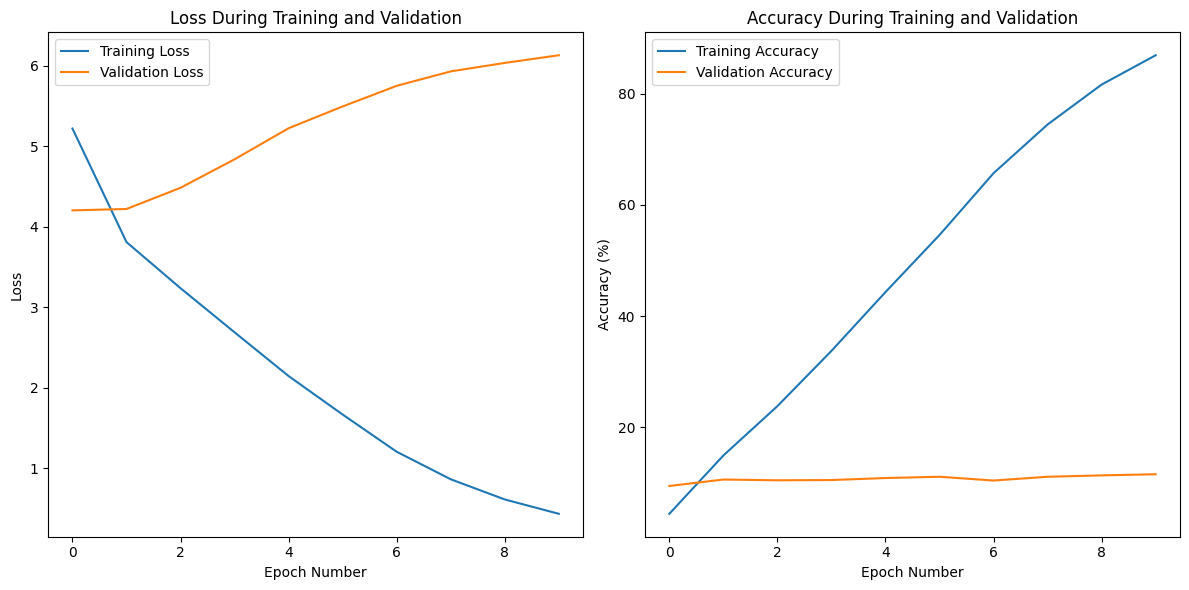

In [22]:
plot_history(val_loss_history, val_accuracy_history, train_loss_history, train_accuracy_history)

In [23]:
label_to_dirname = {key: f"{key}-{value.split('-')[-1].replace('_', ' ')}" for key, value in label_to_dirname.items()}

In [24]:
model.eval()

# Inicializar un diccionario para almacenar las predicciones y etiquetas verdaderas por raza
all_preds = {i: [] for i in range(num_classes)}
all_labels = {i: [] for i in range(num_classes)}

# Mueva el modelo de nuevo a la CPU
model = model.to(device = torch.device("cpu"))

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            all_preds[label].append(pred)
            all_labels[label].append(label)

# Calcular la precisión por raza
accuracy_per_class = {i: accuracy_score(all_labels[i], all_preds[i]) for i in range(num_classes)}

# Crear un DataFrame para fácil manejo
data = {
    'Raza': [label_to_dirname[i] for i in range(num_classes)],
    'Precision': [accuracy_per_class[i] for i in range(num_classes)]
}
df = pd.DataFrame(data)

# Ordenar el DataFrame basado en la precisión
df = df.sort_values(by='Precision')

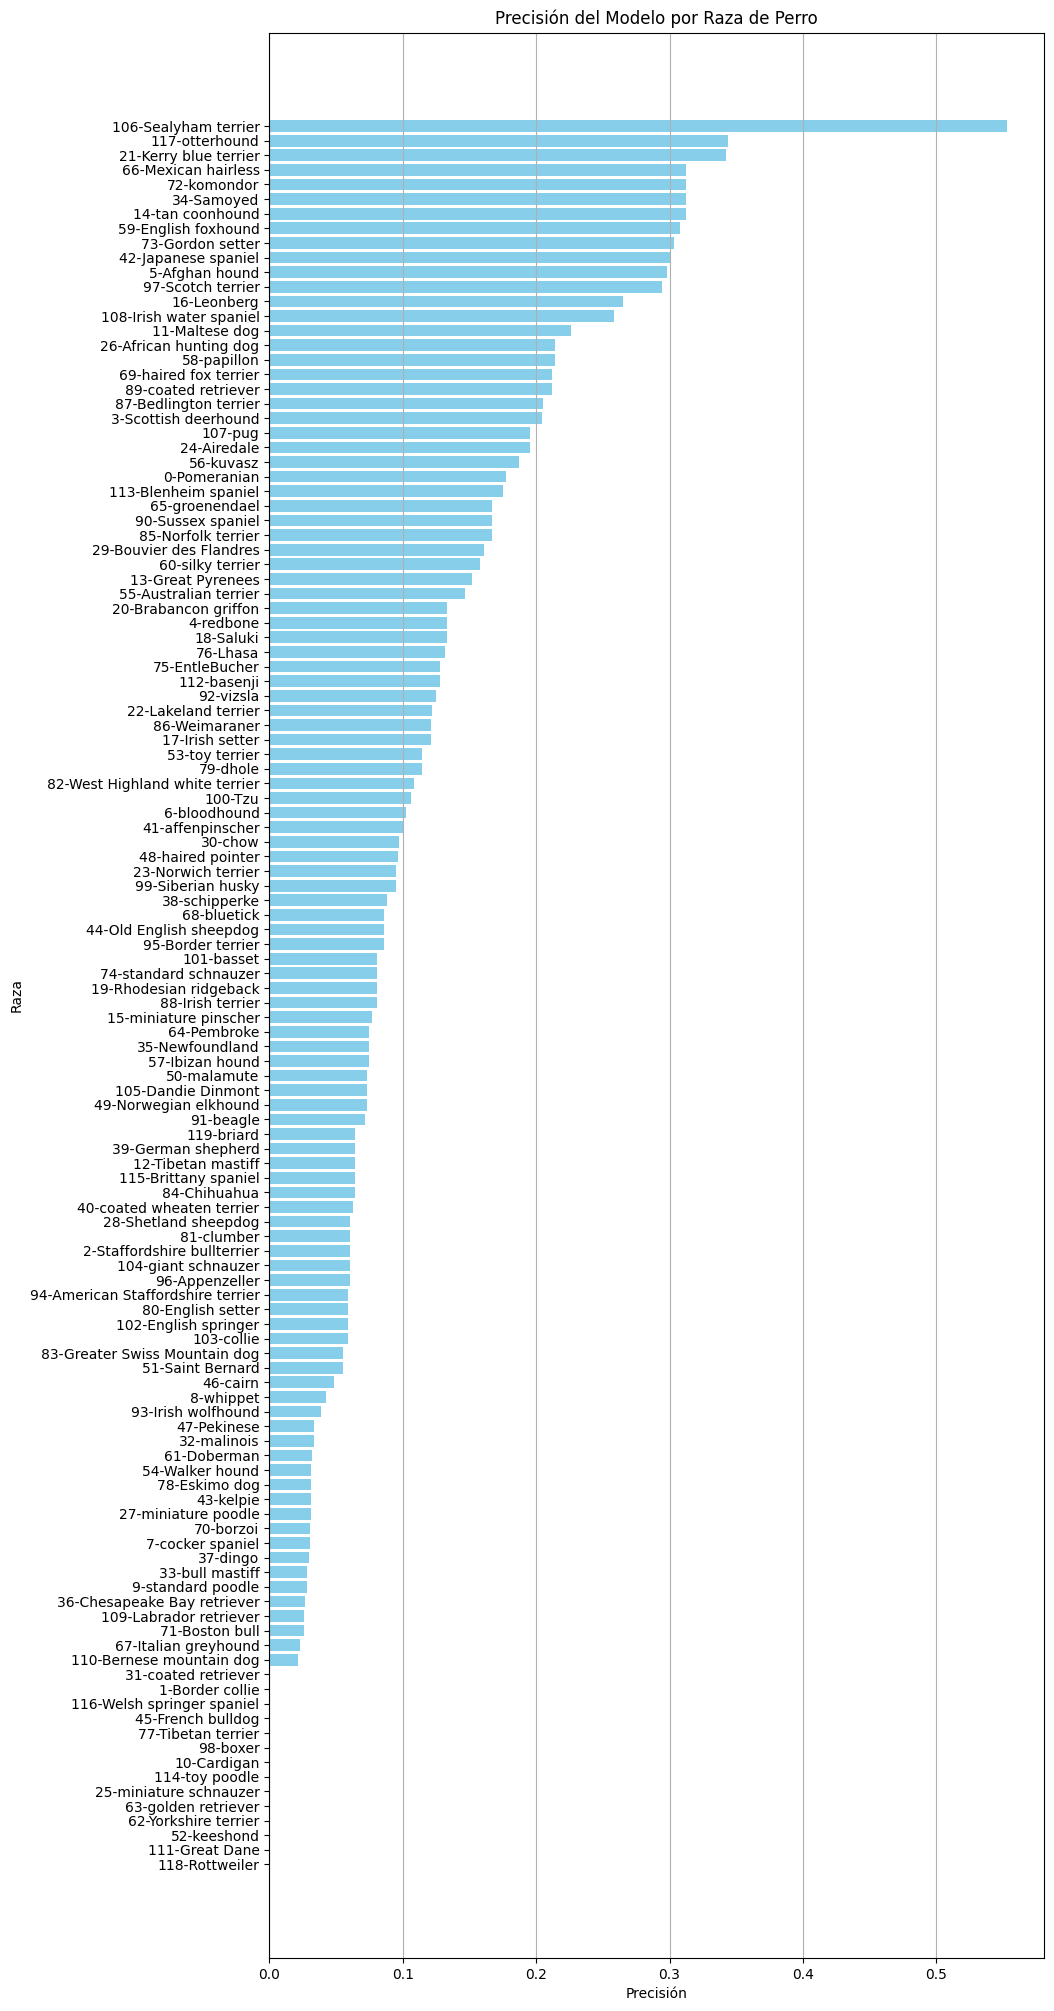

In [25]:
# Crear el gráfico de barras
plt.figure(figsize=(10,25))
plt.barh(df['Raza'], df['Precision'], color='skyblue')
plt.xlabel('Precisión')
plt.ylabel('Raza')
plt.title('Precisión del Modelo por Raza de Perro')
plt.grid(axis='x')
plt.show()
